In [1]:
import os
import torch
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


## CNN on Normalized Image

### Define Dataset

In [2]:
class GestureDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the video frames.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.frame_annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.frame_annotations)

    def __getitem__(self, idx):
        video_id = self.frame_annotations.iloc[idx, 0]  
        label_id = self.frame_annotations.iloc[idx, 3] 

        video_path = os.path.join(self.root_dir, str(video_id))
        frames = self._load_frames(video_path)

        sample = {'frames': frames, 'label_id': label_id}

        if self.transform:
            sample = self.transform(sample)
        return sample

    def _load_frames(self, video_path):
        frame_files = sorted([os.path.join(video_path, f) for f in os.listdir(video_path) if f.endswith('.jpg')])
        frames = [read_image(frame).float() / 255.0 for frame in frame_files] 
        frames = torch.stack(frames, dim=0) # a tensor of shape [depth, channels, height, width]
        frames = frames.permute(1, 0, 2, 3) # [channels, depth, height, width]
        return frames


### Train-Test Split

In [3]:
dataset = GestureDataset(csv_file='data.csv', root_dir='data')

train_indices, test_indices = train_test_split(range(len(dataset)), test_size=0.2, shuffle=False)
train_datase = torch.utils.data.Subset(dataset, train_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

train_indice, val_indices = train_test_split(range(len(train_datase)), test_size=0.25, shuffle=False) # 0.25 x 0.8 = 0.2
train_dataset = torch.utils.data.Subset(train_datase, train_indice)
val_dataset = torch.utils.data.Subset(train_datase, val_indices)

### Model Definition

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Convolutional blocks
        self.conv1 = nn.Sequential(
            nn.Conv3d(in_channels=3, out_channels=32, kernel_size=(3, 3, 3), padding=1, stride=1),
            nn.ReLU(),
            nn.BatchNorm3d(32)
        )
        self.conv2 = nn.Sequential(
            nn.Conv3d(in_channels=32, out_channels=64, kernel_size=(3, 3, 3), padding=1, stride=1),
            nn.ReLU(),
            nn.BatchNorm3d(64)
        )
        self.conv3 = nn.Sequential(
            nn.Conv3d(in_channels=64, out_channels=128, kernel_size=(3, 3, 3), padding=1, stride=1),
            nn.ReLU(),
            nn.BatchNorm3d(128)
        )
        self.conv4 = nn.Sequential(
            nn.Conv3d(in_channels=128, out_channels=256, kernel_size=(3, 3, 3), padding=1, stride=1),
            nn.ReLU(),
            nn.BatchNorm3d(256)
        )
        self.conv5 = nn.Sequential(
            nn.Conv3d(in_channels=256, out_channels=256, kernel_size=(3, 3, 3), padding=1, stride=1),
            nn.ReLU(),
            nn.BatchNorm3d(256)
        )
        
        # Max pooling layer
        self.pool = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))
        
        # LSTM layers
        self.lstm1 = nn.LSTM(input_size=256, hidden_size=256, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=256, hidden_size=256, batch_first=True)
        
        # Fully connected layer
        self.fc = nn.Linear(256, 8)  

        # Global Max Pooling
        self.global_max_pool = nn.AdaptiveMaxPool3d((None, 1, 1))

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.pool(x)
        x = self.conv4(x)
        x = self.conv5(x)
        
        x = self.global_max_pool(x)
        x = x.squeeze(-1).squeeze(-1)
        x = x.permute(0, 2, 1) 
        
        x, _ = self.lstm1(x)
        x, (hn, cn) = self.lstm2(x)
        
        x = hn[-1]  
        
        x = self.fc(x) 
        
        return x


### Load Dataset

In [5]:
batch_size = 512
num_epochs = 50
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


### Check Loader

In [6]:
for batch in train_loader:
    inputs, labels = batch['frames'], batch['label_id']
    print(f'Inputs batch shape: {inputs.size()}')
    print(f'Labels batch shape: {labels.size()}')
    
    print('Frames:', inputs)
    print('Labels:', labels)
    
    break


Inputs batch shape: torch.Size([64, 3, 13, 100, 100])
Labels batch shape: torch.Size([64])
Frames: tensor([[[[[0.4745, 0.6902, 0.8902,  ..., 0.5373, 0.5608, 0.5922],
           [0.4824, 0.6941, 0.8941,  ..., 0.5333, 0.5569, 0.5922],
           [0.4902, 0.7059, 0.9020,  ..., 0.5412, 0.5647, 0.5961],
           ...,
           [0.3608, 0.3333, 0.3216,  ..., 0.0941, 0.0902, 0.0863],
           [0.3569, 0.3255, 0.3137,  ..., 0.0941, 0.0902, 0.0863],
           [0.3529, 0.3216, 0.3098,  ..., 0.0941, 0.0902, 0.0863]],

          [[0.4588, 0.6784, 0.8824,  ..., 0.5333, 0.5608, 0.5961],
           [0.4706, 0.6863, 0.8863,  ..., 0.5333, 0.5569, 0.5961],
           [0.4863, 0.6980, 0.8980,  ..., 0.5412, 0.5647, 0.6039],
           ...,
           [0.3451, 0.3255, 0.3216,  ..., 0.0941, 0.0902, 0.0863],
           [0.3373, 0.3176, 0.3176,  ..., 0.0941, 0.0902, 0.0863],
           [0.3333, 0.3137, 0.3137,  ..., 0.0941, 0.0902, 0.0863]],

          [[0.4471, 0.6588, 0.8627,  ..., 0.5294, 0.5569, 0.5

### Data Distribution

In [22]:
label = []

for i in range(len(train_dataset)):
    label.append (train_dataset[i]['label_id'])

print (np.unique(label))

[0 1 2 3 4 5 6 7]


In [23]:
label = []

for i in range(len(val_dataset)):
    label.append (val_dataset[i]['label_id'])

print (np.unique(label))

[0 1 2 3 4 5 6 7]


In [24]:
label = []

for i in range(len(test_dataset)):
    label.append (test_dataset[i]['label_id'])

print (np.unique(label))

[0 1 2 3 4 5 6 7]


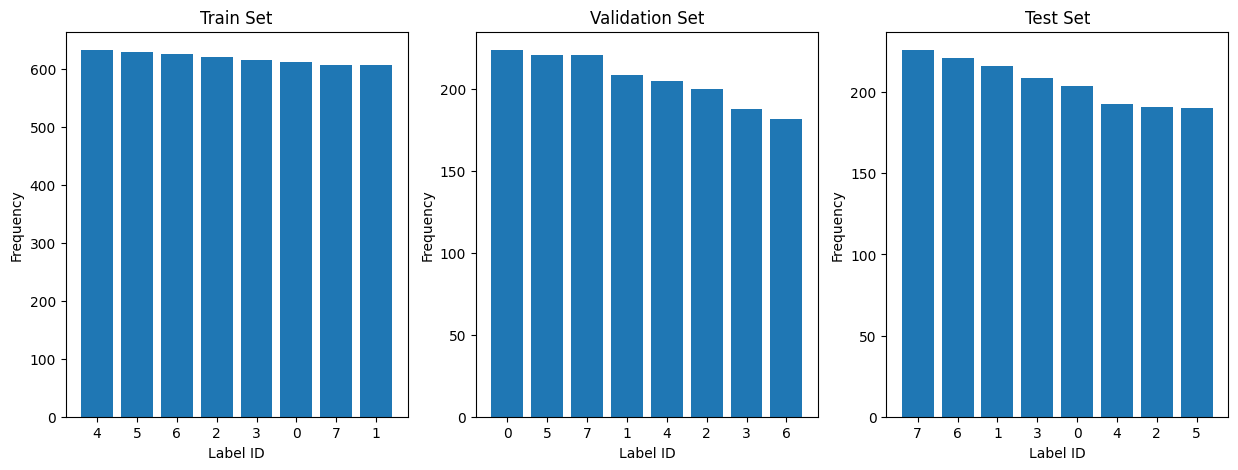

In [32]:
def label_histogram(dataset):
    label = []
    for i in range(len(dataset)):
        label.append (dataset[i]['label_id'])
    df = pd.DataFrame(label, columns=['values'])
    label_counts = df['values'].value_counts().sort_values(ascending=False)
    
    return label_counts
    
dataset = [train_dataset, val_dataset, test_dataset]
titles = ['Train Set', 'Validation Set', 'Test Set']

for i in range(3):
    label_counts = label_histogram(dataset[i])
    plt.gcf().set_size_inches(15, 5)
    plt.subplot(1, 3, i+1)
    plt.bar(label_counts.index.astype(str), label_counts.values)
    plt.xlabel('Label ID')
    plt.ylabel('Frequency')
    plt.title(f'{titles[i]}')


### Train

In [10]:
writer = SummaryWriter('runs/video_classifier_experiment')
loss_list = []
train_acc = []
val_acc = []

def train_model():
    model = CNN().cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0
        
        for data in tqdm(train_loader, total= len(train_dataset)// batch_size):
            inputs, labels = data['frames'], data['label_id']
            
            inputs = inputs.cuda()
            labels = labels.cuda()
            
            optimizer.zero_grad()
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)

        train_accuracy = 100 * correct_preds / total_preds
        writer.add_scalar('training loss', running_loss, epoch)
        writer.add_scalar('training accuracy', train_accuracy, epoch)
        loss_list.append(running_loss)
        train_acc.append(train_accuracy)
        
        

        correct = 0
        total = 0
        with torch.no_grad():
            for data in val_loader:
                inputs, labels = data['frames'], data['label_id']
                
                inputs = inputs.cuda()
                labels = labels.cuda()
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
        val_accuracy = 100 * correct / total
        writer.add_scalar('validation accuracy', val_accuracy, epoch)
        val_acc.append(val_accuracy)
        print(f'Epoch: {epoch}, loss: {running_loss}, train accuracy: {train_accuracy}, val accuracy: {val_accuracy}')
        
    writer.close()
    return model

trained_model = train_model()


  0%|          | 0/9 [00:00<?, ?it/s]

10it [00:42,  4.28s/it]                      


Epoch: 0, loss: 20.62917685508728, train accuracy: 15.443703254497676, val accuracy: 17.393939393939394


10it [00:45,  4.53s/it]                      


Epoch: 1, loss: 18.914363145828247, train accuracy: 25.571053163533456, val accuracy: 33.93939393939394


10it [00:46,  4.61s/it]                      


Epoch: 2, loss: 16.021435260772705, train accuracy: 38.36668688093794, val accuracy: 40.84848484848485


10it [00:37,  3.73s/it]                      


Epoch: 3, loss: 13.300739049911499, train accuracy: 50.47503537497473, val accuracy: 55.93939393939394


10it [00:46,  4.66s/it]                      


Epoch: 4, loss: 10.146628558635712, train accuracy: 60.72367091166363, val accuracy: 66.42424242424242


10it [00:56,  5.62s/it]                      


Epoch: 5, loss: 9.001372456550598, train accuracy: 66.3028097837073, val accuracy: 66.60606060606061


10it [00:37,  3.76s/it]                      


Epoch: 6, loss: 7.499796152114868, train accuracy: 71.90216292702648, val accuracy: 73.87878787878788


10it [00:37,  3.73s/it]                      


Epoch: 7, loss: 5.972105622291565, train accuracy: 78.06751566606025, val accuracy: 75.21212121212122


10it [00:44,  4.48s/it]                      


Epoch: 8, loss: 4.906183868646622, train accuracy: 82.69658378815444, val accuracy: 80.9090909090909


10it [00:46,  4.61s/it]                      


Epoch: 9, loss: 4.075056731700897, train accuracy: 86.45643824540126, val accuracy: 85.0909090909091


10it [00:45,  4.54s/it]                      


Epoch: 10, loss: 3.578054904937744, train accuracy: 87.75015160703457, val accuracy: 85.45454545454545


10it [00:37,  3.72s/it]                      


Epoch: 11, loss: 3.6189417093992233, train accuracy: 87.46715180917728, val accuracy: 84.12121212121212


10it [00:41,  4.19s/it]                      


Epoch: 12, loss: 2.5235279500484467, train accuracy: 91.79300586213867, val accuracy: 86.9090909090909


10it [00:44,  4.43s/it]                      


Epoch: 13, loss: 2.1889726519584656, train accuracy: 92.5207196280574, val accuracy: 88.18181818181819


10it [00:45,  4.57s/it]                      


Epoch: 14, loss: 1.5836095213890076, train accuracy: 95.00707499494644, val accuracy: 87.33333333333333


10it [00:36,  3.69s/it]                      


Epoch: 15, loss: 1.3371184170246124, train accuracy: 95.75500303214069, val accuracy: 89.33333333333333


10it [00:37,  3.73s/it]                      


Epoch: 16, loss: 1.0536934733390808, train accuracy: 96.72528805336567, val accuracy: 87.33333333333333


10it [00:45,  4.57s/it]                      


Epoch: 17, loss: 0.8025174662470818, train accuracy: 97.69557307459065, val accuracy: 89.39393939393939


10it [00:45,  4.59s/it]                      


Epoch: 18, loss: 0.8089126981794834, train accuracy: 97.29128764908025, val accuracy: 86.72727272727273


10it [00:45,  4.60s/it]                      


Epoch: 19, loss: 0.7957754582166672, train accuracy: 97.29128764908025, val accuracy: 89.33333333333333


10it [00:37,  3.77s/it]                      


Epoch: 20, loss: 0.667632196098566, train accuracy: 97.8370729735193, val accuracy: 89.27272727272727


10it [00:41,  4.14s/it]                      


Epoch: 21, loss: 0.4656762257218361, train accuracy: 98.62542955326461, val accuracy: 90.18181818181819


10it [00:53,  5.32s/it]                      


Epoch: 22, loss: 0.46750651486217976, train accuracy: 98.48392965433597, val accuracy: 88.78787878787878


10it [00:37,  3.73s/it]                      


Epoch: 23, loss: 0.6152271628379822, train accuracy: 98.09985850010108, val accuracy: 89.0909090909091


10it [00:39,  3.93s/it]                      


Epoch: 24, loss: 0.6739698685705662, train accuracy: 97.91793005862138, val accuracy: 89.63636363636364


10it [01:07,  6.72s/it]                      


Epoch: 25, loss: 0.4183649756014347, train accuracy: 98.86800080857086, val accuracy: 89.15151515151516


10it [01:05,  6.59s/it]                      


Epoch: 26, loss: 0.31133027095347643, train accuracy: 99.04992925005054, val accuracy: 90.36363636363636


10it [00:54,  5.43s/it]                      


Epoch: 27, loss: 0.23970818612724543, train accuracy: 99.3127147766323, val accuracy: 90.3030303030303


10it [00:41,  4.19s/it]                      


Epoch: 28, loss: 0.17035202542319894, train accuracy: 99.45421467556095, val accuracy: 89.57575757575758


10it [00:47,  4.72s/it]                      


Epoch: 29, loss: 0.3371741222217679, train accuracy: 98.84778653729533, val accuracy: 90.66666666666667


10it [00:45,  4.58s/it]                      


Epoch: 30, loss: 0.32447854429483414, train accuracy: 98.92864362239742, val accuracy: 90.24242424242425


10it [00:45,  4.56s/it]                      


Epoch: 31, loss: 0.281076998449862, train accuracy: 99.2116434202547, val accuracy: 90.0


10it [00:37,  3.73s/it]                      


Epoch: 32, loss: 0.1589686404913664, train accuracy: 99.57550030321407, val accuracy: 88.42424242424242


10it [00:42,  4.27s/it]                      


Epoch: 33, loss: 0.10459115356206894, train accuracy: 99.63614311704063, val accuracy: 90.18181818181819


10it [00:44,  4.40s/it]                      


Epoch: 34, loss: 0.1683094627223909, train accuracy: 99.43400040428543, val accuracy: 90.78787878787878


10it [00:45,  4.57s/it]                      


Epoch: 35, loss: 0.08850081940181553, train accuracy: 99.73721447341823, val accuracy: 90.42424242424242


10it [00:37,  3.79s/it]                      


Epoch: 36, loss: 0.08406981662847102, train accuracy: 99.81807155852032, val accuracy: 90.3030303030303


10it [00:44,  4.46s/it]                      


Epoch: 37, loss: 0.05644548579584807, train accuracy: 99.83828582979584, val accuracy: 90.9090909090909


10it [00:47,  4.73s/it]                      


Epoch: 38, loss: 0.07528183469548821, train accuracy: 99.81807155852032, val accuracy: 91.15151515151516


10it [01:05,  6.56s/it]                      


Epoch: 39, loss: 0.19920889823697507, train accuracy: 99.27228623408126, val accuracy: 89.39393939393939


10it [00:45,  4.59s/it]                      


Epoch: 40, loss: 0.28900949377566576, train accuracy: 98.96907216494846, val accuracy: 87.81818181818181


10it [00:37,  3.73s/it]                      


Epoch: 41, loss: 0.2517143776640296, train accuracy: 99.15100060642814, val accuracy: 87.57575757575758


10it [00:42,  4.26s/it]                      


Epoch: 42, loss: 0.31995471380650997, train accuracy: 98.96907216494846, val accuracy: 87.39393939393939


10it [00:47,  4.74s/it]                      


Epoch: 43, loss: 0.5130519606173038, train accuracy: 98.28178694158076, val accuracy: 89.27272727272727


10it [00:45,  4.60s/it]                      


Epoch: 44, loss: 0.5442090164870024, train accuracy: 98.09985850010108, val accuracy: 90.06060606060606


10it [00:37,  3.71s/it]                      


Epoch: 45, loss: 0.28353084065020084, train accuracy: 99.15100060642814, val accuracy: 88.84848484848484


10it [00:37,  3.72s/it]                      


Epoch: 46, loss: 0.2593275150284171, train accuracy: 99.1105720638771, val accuracy: 89.33333333333333


10it [00:37,  3.75s/it]                      


Epoch: 47, loss: 0.2270850883796811, train accuracy: 99.33292904790783, val accuracy: 90.54545454545455


10it [00:47,  4.79s/it]                      


Epoch: 48, loss: 0.14709327509626746, train accuracy: 99.53507176066303, val accuracy: 90.18181818181819


10it [00:54,  5.46s/it]                      


Epoch: 49, loss: 0.11782089900225401, train accuracy: 99.71700020214271, val accuracy: 90.42424242424242


In [11]:
torch.save(trained_model, 'CNN_model')

### Plot

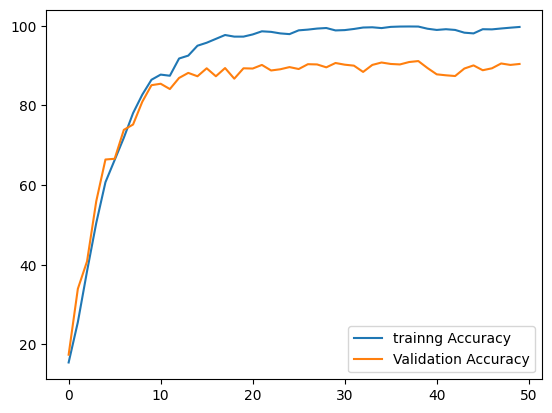

In [18]:
plt.plot(np.arange(0, num_epochs), train_acc, label='trainng Accuracy')
plt.plot(np.arange(0, num_epochs), val_acc, label='Validation Accuracy')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


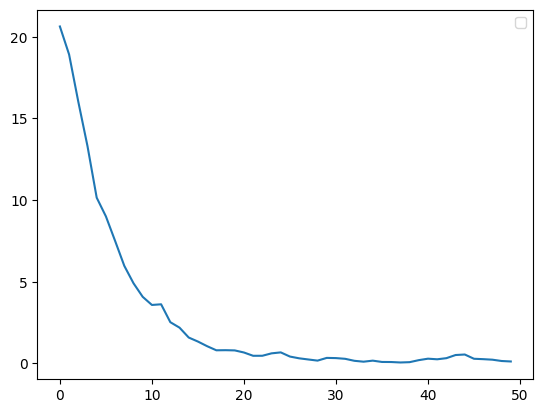

In [19]:
plt.plot(np.arange(0, num_epochs), loss_list)
plt.legend()
plt.show()

### Evaluation

In [13]:
def test_model(model, test_loader):
    model = model.cuda()
    model.eval()  
    correct = 0
    total = 0
    with torch.no_grad(): 
        for data in test_loader:
            inputs, labels = data['frames'], data['label_id']
            inputs, labels = inputs.cuda(), labels.cuda()

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the test set: {accuracy:.2f}%')
    return accuracy


test_accuracy = test_model(trained_model, test_loader)


Accuracy of the model on the test set: 89.76%


In [10]:
model = CNN()
model = torch.load('CNN_model_normalized.pt')
model.cuda()
model.eval()

CNN(
  (conv1): Sequential(
    (0): Conv3d(3, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): ReLU()
    (2): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): ReLU()
    (2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): ReLU()
    (2): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): ReLU()
    (2): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv5): Sequential(
    (0): Conv3d(256, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): ReLU()
  

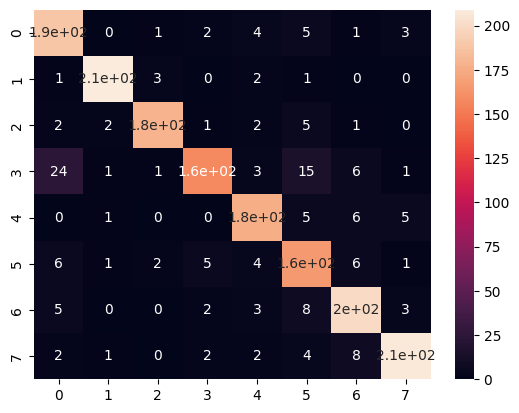

In [11]:
all_preds = []
all_labels = []

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data['frames'], data['label_id']
        inputs, labels = inputs.cuda(), labels.cuda()
        
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
cm = confusion_matrix(all_labels, all_preds)


sns.heatmap(cm, annot=True)
plt.show()
